<a href="https://colab.research.google.com/github/RoSchilling/MVP_Analise_2_Etapa/blob/main/MV_Analise_2_Etapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução


O presente notebook faz parte da segunda entrega da Especialização em Ciência de Dados e Analytics da PUC-RIO. Este documento foi dividido em três partes:

A primeira parte contém os pacotes utilizados neste notebook, a importação dos dataframes necessários e funções que foram criadas com o objetivo de facilitar a analise dos dados.

Na segunda etapa, realizamos a análise da base de dados 'Bank Marketing', disponível no UCI e no ambiente do Github junto a este documento. Desenvolvemos um modelo de classificação para compreender as características dos clientes do banco e prever se eles iriam realizar um depósito a termo ou não.

Na terceira etapa, analisamos o dataset 'Brazil - Monetary Policy Committee Minutes', disponibilizado no Kaggle. Neste momento, aplicamos técnicas de Processamento de Linguagem Natural (NLP) para entender melhor o conteúdo das minutas das atas do Comitê de Política Monetária brasileiro.

A descrição do problema, a formulação das hipóteses e a descrição dos dados para cada uma das análises foram elaboradas no tópico denominado 'Contextualização' de cada respectiva etapa referente ao treinamento dos modelos.

# 1. Processo iniciais

## 1.1 - Importando os pacotes

In [1]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários Classificação
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo
from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Classificação
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVM
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Imports necessários PLN
import re  # For preprocessing
import nltk
from nltk.tokenize import word_tokenize # Para criar tokens das palavras
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import spacy  # For preprocessing
import logging  # Setting up the loggings to monitor gensim
from spacy.lang.pt.examples import sentences
import multiprocessing
from gensim.models import Word2Vec
from nltk.probability import FreqDist

## 1.2 Carregando o DataFrame

## 1.2.1 Importando dados de Classificação

In [2]:
# Configurando o URL da base de dados
url = 'https://raw.githubusercontent.com/RoSchilling/MVP_Analise_2_Etapa/main/bank-full.csv'

bank = pd.read_csv(url, sep=';')

## 1.2.2 Importando dados de PLN

In [3]:
url = 'https://raw.githubusercontent.com/RoSchilling/MVP_Analise_2_Etapa/main/bcb-copom.csv'

compom = pd.read_csv(url)

## 1.3 - Funções Úteis

In [4]:
# Função para retirar os caracteres expeciais
def limpar_texto(texto):
    clean_text = re.sub(r'[^\w\s]+', ' ', texto)

    return clean_text

# Função para verificar a frequencia das palavras
def cleaning(doc):
  # Flexionando e removendo as stopwords
  txt = [
      token.lemma_ for token in doc if not token.is_stop
  ]
  if len(txt) > 2:
    return ' '.join(txt)




# 2. Modelo de Classificação

## 2.1 Contextualização

O modelo de classificação visa determinar se determinado agente 'X' se enquandra em um de duas caracteristicas que são esperadas com base na hipotése determinada pelo analista. Conforme informado na introdução deste notebook os dados que serão analisados nesta etapa são referentes a base 'Bank Marketing' disponível no UCI. A analise será guiada pela seguinte hipotese: "Um novo cliente da instuição bancária irá realizar um deposito a termo 'sim' ou 'não'?"

Como a variável resposta pode ser resumida em duas varíaveis categoricas de 'sim' para os clientes que irão realizar o deposito a termo e 'não' para os que não utilizaram desta modalidade foi utilizada as técnicas de classificação das varíaveis de entrada buscando comprrender quais carecteristicas são comuns ao clientes que adquiriram cada uma destas etapas.

Conforme será demonstrado no decorrer do script foi necessário realizar a preparação dos dados para que fosse possível realizar a modelagem, uma vez que o dataset possíu dados categoricos e númericos. Para os dados categoricos ainda foi necessário criar dois tipos de encoding para os atribuitos, já que algumas colunas possuíam mais de uma tipificação para os clientes enquanto outras são determinadas por apenas 'sim' e 'não'.

Ademais será realizado antes da modelagem o processo de criação de uma *base line* com o objetivo de entender quais modelos conseguem gerar uma melhor classificação dos dados. Por fim será utilizado o metódo de *feature selection* para selecionar os melhores atributos para o modelo excluindo os dados redundantes com o objetivo de tornar o modelo mais acurado.



## 2.1 - Analise preliminar dos dados

### 2.1.1 - Analise descritiva

In [5]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
bank.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


Conforme é possível verificar na documentação da base e após plotar as cinco primeiras e cinco últimas linhas nota-se que é necessário alterar os valores para o tipo númerio com '1' sendo 'yes' e '0' 'no'. Será necessário ajustar as colunas de entrada para que essas tenham uma representação númerica ao invés de categorica, para isso será utilizado o metodo *dummy enconding*, já as variáveis com mais de um retorno categorico será utilizado o metódo de *one-hot-encoding*. Contudo antes da etapa de ajustes do dataset para a modelagem é necessário verificar se existem valores nulos e a analise de correlação dos dados.


In [7]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Com base na função 'info' nota-se que não existe valores nulos no data frame, isso implica na não necessidade de se realizar os tratamentos para retirar os missings (valores nulos) do data frame. A função describe permite analizar a estatísticas descritivas, como quantidade, média, valor máximo e minímo, entre outros das varíveis númericas.

In [8]:
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


## 2.2 Ajustes no Data Frame

### 2.1.1 Transformando as Váriaveis categoricas em númericas

In [9]:
# Criando uma cópia do Data Frame
bank_dummy = bank.copy()

# Separando as variáveis categoricas e númericas
col_categoricas = bank_dummy.select_dtypes(include="object").columns
print("As colunas categoricas são:",list(col_categoricas), 'a quantidade de colunas categoricas é', len(col_categoricas),
      'o número total de colunas do df é', len(bank_dummy.columns),',',
      '\nas colunas categoricas representam',round(len(col_categoricas)/len(bank_dummy.columns)*100),'%')


As colunas categoricas são: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y'] a quantidade de colunas categoricas é 10 o número total de colunas do df é 17 , 
as colunas categoricas representam 59 %


In [10]:
# Alterando os valore 'yes' para '1' e 'no' para '0'
for col in col_categoricas:
   if bank_dummy[col].nunique() == 2:
        bank_dummy[col] = np.where(bank_dummy[col] == "yes", 1, 0)

# Verificando o data frame alterado
bank_dummy.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0


Após alterar as colunas com os valores 'yes' e 'no' é necessário criar o one-hot-encoding para as varíaveis não binárias do data frame.

In [11]:
# Criando uma cópia do data frame com as varívaies binárias alteradas
bank_one_hot = bank_dummy.copy()

# Criando as dummies one-hot
bank_one_hot = pd.get_dummies(bank_one_hot)

#Verificando o novo DF
bank_one_hot.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,261,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
1,44,0,29,1,0,5,151,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
2,33,0,2,1,1,5,76,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
3,47,0,1506,1,0,5,92,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
4,33,0,1,0,0,5,198,1,-1,0,...,0,0,1,0,0,0,0,0,0,1


In [12]:
print(
    'Nota-se que o dataframe original continha',len(bank.columns), 'colunas, enquanto o novo data frame contém', len(bank_one_hot.columns), 'colunas,\nisto representa um aumento de',
    len(bank_one_hot.columns)-len(bank.columns), 'colunas no dataframe'
)

Nota-se que o dataframe original continha 17 colunas, enquanto o novo data frame contém 49 colunas,
isto representa um aumento de 32 colunas no dataframe


## 2.3 Treinando o modelo

### 2.3.1 Preparando os dados

In [13]:
# Criando uma cópia para a modelagem
df_modelo = bank_one_hot.copy()

# Alterando o nome da variável target
df_modelo = df_modelo.rename({'y':'target'}, axis=1)

# Ajustando a variável explicativa
X = df_modelo.copy()
X = X.drop('target', axis=1)

# Ajustando variável de saída
y = df_modelo['target']

# Separando os dados de treino e de teste, será utilizado 80% do dataset para treino e 20% para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Criando os folds para validação cruzada
num_particoes = 10

# Realizando a partição em 10 folds
Kfold = KFold(n_splits= num_particoes, shuffle = True, random_state=7)


## 2.4 Modelagem

### 2.4.1 Base Line

KNN: 0.883129 (0.005003)
CART: 0.875995 (0.005613)
NB: 0.852411 (0.006330)
SVM: 0.881691 (0.003015)


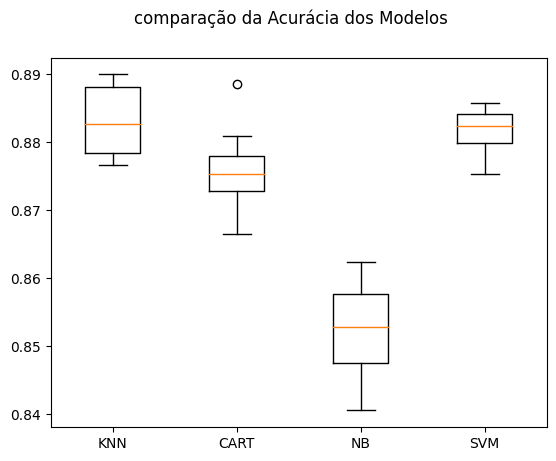

In [14]:
# Definindo o seed para a célula
seed = 1000
np.random.seed(seed)

# Adicionando as listas para armazenar os modelos, os resultados e os nomes
models = []
results = []
names = []

# Preparando os modelos e adicionando a lista 'models'
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Ajustando o loop 'for' para criar um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=Kfold, scoring='accuracy')
  results.append(cv_results)
  names.append(name)

  # Verificando a média e o desvio padrão dos 10 resultados da validação cruzada
  msg = '%s: %f (%f)'%(name, cv_results.mean(), cv_results.std())

  print(msg)

# Plotando gráfico de comparação dos modelos
fig = plt.figure()
fig.suptitle('comparação da Acurácia dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Nota-se que os modelos KNN e SVM tiveram os melhores resultads do modelo, para entender qual dentre eles teve a melhor acurácia será efetuado dois testes de acuracia comparando os resultados do modelo de teste com o modelo de treino.

### 2.4.1 Testando a Acurácia do modelo KNN

In [15]:
# Criando o coleno com o conjunto de treino
modelo = KNeighborsClassifier()
modelo.fit(X_train, y_train)

# Utilizando o modelo de test para realizar as predições
predictions = modelo.predict(X_test)

# Calculando a acurácia
acuracia = accuracy_score(y_test, predictions)

print('A acurácia foi %.2f%%' % (acuracia*100))

A acurácia foi 88.30%


### 2.4.2 Testando a Acurácia do modelo SVM

In [16]:
# Criando o coleno com o conjunto de treino
modelo = SVC()
modelo.fit(X_train, y_train)

# Utilizando o modelo de test para realizar as predições
predictions = modelo.predict(X_test)

# Calculando a acurácia
acuracia = accuracy_score(y_test, predictions)

print('A acurácia foi %.2f%%' % (acuracia*100))

A acurácia foi 88.81%


Conforme é possível observar os resultados do modelo de Support Vector Machine e do K-Neighbors - Classifier tiveram uma acurácia muito similiar com o Data set de treino conseguindo classificar de maneira adqueda a maior parte dos dados de entrada. Irão ser utilizados os metodos de otimização, padronização e normalização dados para ver qual a melhor metrica para estes.

### 2.4.3 Padronizando e normalizando os dados

KNN-orig: 0.883 (0.005)
SVM-orig: 0.882 (0.003)
KNN-padr: 0.891 (0.003)
SVM-padr: 0.902 (0.003)
KNN-norm: 0.888 (0.004)
SVM-norm: 0.894 (0.002)


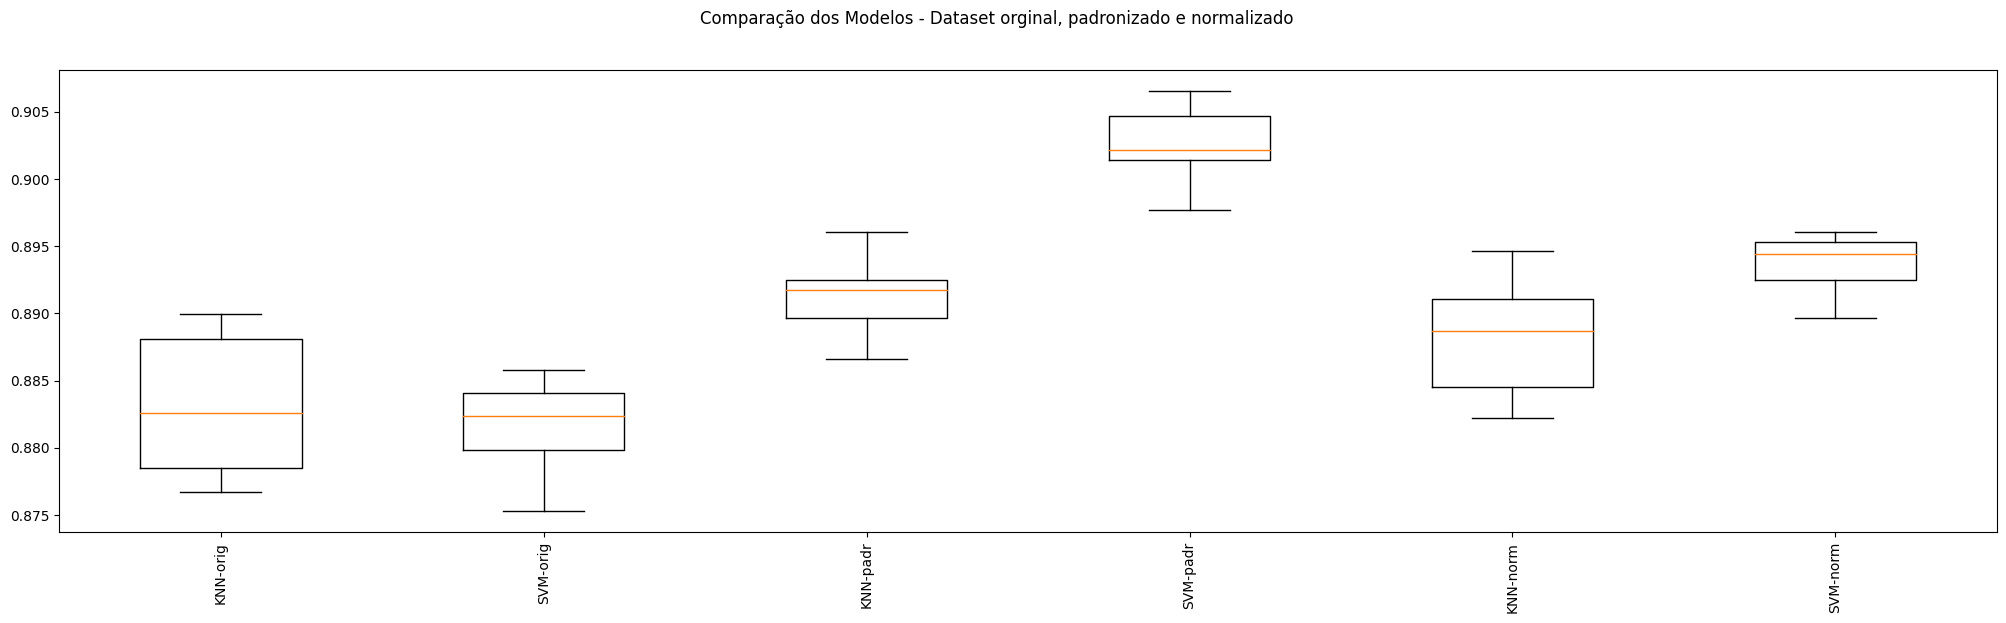

In [17]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('SVM-orig', Pipeline([svm])))


# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))


# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))


# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=Kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

Conforme podemos observar no gráfico acima, há um marginal na capacidade de previsão do modelo quando os dados são normalizados e padronizados. No entanto, esse ganho é mais superior ao realizar o processo de padronização em relação ao processo de normalização, especialmente no método SVM.

### 2.4.4 Otimizando os hiperparâmetros

#### 2.4.4.1 KNN

In [44]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=Kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: knn-orig - Melhor: 0.887082 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 15}
Sem tratamento de missings: knn-padr - Melhor: 0.895156 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 15}
Sem tratamento de missings: knn-norm - Melhor: 0.893027 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 21}


Nota-se que com a otimização dos hiperparametro o modelo KNN, conforme observado anteriormente, tem o seu melhor resultado por meio da Padronização utilizando a medida Euclidiana.

## 2.5 Conclusão modelo de classificação

Após treinar o modelo e relizar o teste da acuracia ficou evidente que o modelo de KNN e SVM foram os que conseguiram melhor aprender o comportamento dos dados e desta maneira gerar o melhor classificador para os clientes do banco, com uma acuracia de 88,30% e 88,81% nos parêmetros origianais.

Ao realizar a normalização e padronização dos dados houve uma melhora marginal do resultado de ambos os modelos. A padronização dos dados se mostrou mais eficaz para melhorar a resposta do modelo.Contudo é importante ressaltar que o ganho da padronização não aumentou de maneira significativa o resultado dos modelos, sendo possível utilizar os resultados originais do teste para obter bons resultados.

Neste sentido após estas etapas de treinamento seria possível utilizar o modelo em produção para classificar os novos clientes do banco com o objetivo de melhorar a tomada de decisão dos lideres.



# 3. Processamento de linguagem natural

## 3.1 Contextualização

O modelo de Processamento de Linguagem Natural consiste em analisar um conjunto de dados textuais seja de relatórios, textos, tweets e buscar por meio da analise destes dados as similaridades entre as palavras contidas em frases ou paragrafos. Desta forma é possível treinar o modelo para realizar uma analise de sentimentos ou mesmo treinar a máquina para ser capaz de traduzir texto como é o caso do *Google Translate* ou gerar novos texto como o *Chat-GPT*.

Nesta notebook, conforme exposto anteriormente, será analisada a base de dados disponível no Keagle 'Brazil - Monetary Policy Committee Minutes'. O objetivo da analise e entender quais são as principais palavras chaves, que podem expressar as preocupações da autorizade monetária brasileira.

Esta etapa foi dividida em terês etapas, sendo primeiro realizada uma analise preliminar buscando comprender quais são as principais palavras chaves contidas nas minutas. Em seguida foi realizado o pré-processamento dos dados separando por frases, para que estas sejam inseridas no modelo a ser treinado.

Por fim, foi rodado o modelo e buscou-se compreender em qual contexto as principais palavras chaves estavam inseridas. Ao final deste bloco contém a conclusão da analise do modelo.

## 3.2 Analise preliminar

In [20]:
compom.head()

,title,link,text
0,"BC - Copom Ata - 250ª Reunião - 25-26 outubro,...",https://www.bcb.gov.br/publicacoes/atascopom/2...,1. O ambiente externo mantém-se adverso e volá...
1,BC - Copom Ata - 249ª Reunião - 20-21 setembro...,https://www.bcb.gov.br/publicacoes/atascopom/2...,1. O ambiente externo mantém-se adverso e volá...
2,"BC - Copom Ata - 248ª Reunião - 2-3 agosto, 2022",https://www.bcb.gov.br/publicacoes/atascopom/0...,1. O ambiente externo mantém-se adverso e volá...
3,"BC - Copom Ata - 247ª Reunião - 14-15 junho, 2022",https://www.bcb.gov.br/publicacoes/atascopom/1...,"1. O ambiente externo seguiu se deteriorando, ..."
4,"BC - Copom Ata - 246ª Reunião - 3-4 maio, 2022",https://www.bcb.gov.br/publicacoes/atascopom/0...,"1. No cenário externo, o ambiente global segui..."


In [21]:
# Criando data frame apenas com os dados 'text'
texto = pd.DataFrame({'text':compom['text']})

texto.head()


,text
0,1. O ambiente externo mantém-se adverso e volá...
1,1. O ambiente externo mantém-se adverso e volá...
2,1. O ambiente externo mantém-se adverso e volá...
3,"1. O ambiente externo seguiu se deteriorando, ..."
4,"1. No cenário externo, o ambiente global segui..."


In [22]:
# Copiando o data frame
texto_limpo = texto.copy()

# Retirando os caracteres especiais
texto_limpo['text'] = texto_limpo['text'].apply(limpar_texto)

# Ajustando as palavras em textos minusculos para impedir texto iguais escritos de maneira diferente
texto_limpo['text'] = texto_limpo['text'].str.lower()

# Baixando conjunto de tokens
nltk.download('punkt')

# Concatenando os elementos da serie em uma string
texto_completo = ' '.join(texto_limpo['text'])

# Criando a tokenizalçai das palavras
tokens = nltk.word_tokenize(texto_completo)

# Verificando os ajustes
print(texto_limpo)
print(tokens)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                                text
0  1  o ambiente externo mantém se adverso e volá...
1  1  o ambiente externo mantém se adverso e volá...
2  1  o ambiente externo mantém se adverso e volá...
3  1  o ambiente externo seguiu se deteriorando  ...
4  1  no cenário externo  o ambiente global segui...
5  1  no cenário externo  o ambiente se deterioro...
6  1  no cenário externo  o ambiente segue menos ...
7  1  no cenário externo  o ambiente se tornou me...
8  1  no cenário externo  o ambiente tem se torna...
9  1  no cenário externo  os estímulos monetários...
['1', 'o', 'ambiente', 'externo', 'mantém', 'se', 'adverso', 'e', 'volátil', 'com', 'revisões', 'negativas', 'para', 'o', 'crescimento', 'global', 'o', 'aperto', 'das', 'condições', 'financeiras', 'nas', 'principais', 'economias', 'a', 'continuidade', 'da', 'guerra', 'na', 'ucrânia', 'com', 'suas', 'consequências', 'sobre', 'o', 'fornecimento', 'de', 'energia', 'para', 'a', 'europa', 'e', 'a', 'manutenção', 'da', 

In [23]:
nltk.download('stopwords')
from nltk.corpus import stopwords

# criando lista com as palavras de parada
stop_words = stopwords.words('portuguese')

# Removendo as stop words
filtered_review = [
    word for word in tokens if word not in stop_words
]

print(filtered_review)

['1', 'ambiente', 'externo', 'mantém', 'adverso', 'volátil', 'revisões', 'negativas', 'crescimento', 'global', 'aperto', 'condições', 'financeiras', 'principais', 'economias', 'continuidade', 'guerra', 'ucrânia', 'consequências', 'sobre', 'fornecimento', 'energia', 'europa', 'manutenção', 'política', 'combate', 'covid', '19', 'china', 'reforçam', 'perspectiva', 'desaceleração', 'crescimento', 'global', 'próximos', 'trimestres', '2', 'ambiente', 'inflacionário', 'segue', 'desafiador', 'observa', 'normalização', 'incipiente', 'cadeias', 'suprimento', 'acomodação', 'preços', 'principais', 'commodities', 'período', 'recente', 'deve', 'levar', 'moderação', 'pressões', 'inflacionárias', 'globais', 'ligadas', 'bens', 'outro', 'lado', 'baixo', 'grau', 'ociosidade', 'mercado', 'trabalho', 'algumas', 'economias', 'aliado', 'inflação', 'corrente', 'elevada', 'alto', 'grau', 'difusão', 'sugere', 'pressões', 'inflacionárias', 'setor', 'serviços', 'podem', 'demorar', 'dissipar', '3', 'processo', 'no

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
nltk.download('rslp')

stemmer = nltk.stem.RSLPStemmer()

# removendo os afixos morfológicos das palavras
stemmed_review = [stemmer.stem(word) for word in filtered_review]

print(stemmed_review)

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


['1', 'ambi', 'extern', 'mantém', 'advers', 'volátil', 'revis', 'nega', 'cresc', 'glob', 'apert', 'cond', 'financ', 'princip', 'econom', 'continu', 'guerr', 'ucrân', 'consequ', 'sobr', 'fornec', 'energ', 'europ', 'manutenç', 'polít', 'combat', 'covid', '19', 'chin', 'reforç', 'perspec', 'desaceler', 'cresc', 'glob', 'próx', 'trimestr', '2', 'ambi', 'inflacion', 'seg', 'desafi', 'observ', 'normal', 'incipi', 'cade', 'supr', 'acomod', 'preç', 'princip', 'commoditi', 'períod', 'recent', 'dev', 'lev', 'moder', 'press', 'inflacionár', 'glob', 'lig', 'bem', 'outr', 'lad', 'baix', 'grau', 'ocios', 'merc', 'trabalh', 'algum', 'econom', 'ali', 'infl', 'corr', 'elev', 'alt', 'grau', 'difus', 'sug', 'press', 'inflacionár', 'set', 'serviç', 'pod', 'demor', 'dissip', '3', 'process', 'normal', 'polít', 'monetár', 'país', 'avanç', 'prosseg', 'direç', 'tax', 'restri', 'form', 'sincron', 'país', 'apert', 'cond', 'financ', 'impact', 'expect', 'cresc', 'econôm', 'elev', 'risc', 'mov', 'abrupt', 'reprecif

In [25]:
# Criando variável com as palavras principais
fd = FreqDist(filtered_review)

# verificando a frequencia das palavras
for word in list(fd.keys())[:20]:
  print(word, fd[word])

1 33
ambiente 30
externo 10
mantém 9
adverso 3
volátil 8
revisões 8
negativas 6
crescimento 44
global 34
aperto 43
condições 18
financeiras 16
principais 11
economias 30
continuidade 3
guerra 10
ucrânia 11
consequências 7
sobre 54


Após a analise prelimar é possível notar que as palavras, 'crescimento', 'sobre' e 'aperto' são as princiapis do texto. Contudo, o número '1' também aparece com frequência neste sentido será necessário retirar essa númeral do texto. A palavra sobre não tem muita importancia para a analise, uma vez que ela é utilizada para dar sentido a frase, como por exemplo: 'O aumento da inflação nos Estados Unidos tem um impacto **sobre** os preços no Brasil' neste caso seria interessante verificar as palavras 'inflação' e 'preço' que são importantes para a analise economica.

## 3.3 Pré-processamento dos dados

In [29]:
# Criando cópia do dataframe original
df_text = texto.copy()

# importando dados para analise
spacy.cli.download('pt_core_news_sm')
nlp = spacy.load('pt_core_news_sm', disable=['ner', 'parser'])

# Retirando o número '1' do texto
df_clean = df_text['text'].replace({'1.':''}, regex = True)

# Transformando a base em uma coluna tipo 'text'
df_clean = ' '.join(df_clean.tolist())

# removendo caracteres não-alfa numéricos
df_clean = re.sub(r'[^\w\s]', '', df_clean)

# colocando o texto em minusculo
df_clean = df_clean.lower()

t = time()
doc = nlp(df_clean)
txt = cleaning(doc)

print('O tempo para limpar tudo foi de: {} min'.format(round((time() - t) / 60, 2)))

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
O tempo para limpar tudo foi de: 0.04 min


In [30]:
txt = txt.split('\n')

In [31]:
data_dict = {'clean': txt}
df = pd.DataFrame(data_dict)
df = df.dropna().drop_duplicates()
df.shape

(2, 1)

In [32]:
!pip install gensim
from gensim.models.phrases import Phrases, Phraser

In [33]:
sent = [
    row.split() for row in df['clean']
]

sent

[['ambiente',
  'externo',
  'Mantémse',
  'adverso',
  'volátil',
  'revisão',
  'negativo',
  'crescimento',
  'global',
  'aperto',
  'condição',
  'financeiro',
  'principal',
  'economia',
  'continuidade',
  'guerra',
  'ucrânia',
  'consequência',
  'fornecimento',
  'energia',
  'Europa',
  'manutenção',
  'política',
  'combate',
  'covid',
  'china',
  'reforçar',
  'perspectiva',
  'desaceleração',
  'crescimento',
  'global',
  'próximo',
  'trimestr',
  '2',
  'ambiente',
  'inflacionário',
  'seguir',
  'desafiador',
  'observaser',
  'normalização',
  'incipiente',
  'cadeia',
  'suprimento',
  'acomodação',
  'preço',
  'principal',
  'commodities',
  'período',
  'recente',
  'levar',
  'moderação',
  'pressão',
  'inflacionário',
  'global',
  'ligar',
  'bem',
  'outro',
  'grau',
  'ociosidade',
  'mercado',
  'trabalho',
  'economia',
  'aliar',
  'inflação',
  'elevar',
  'alto',
  'grau',
  'difusão',
  'sugerir',
  'pressão',
  'inflacionário',
  'setor',
  'ser

In [34]:
frases = Phrases(sent, min_count=1, progress_per=10)
frases

In [35]:
bigram = Phraser(frases)
sentences = bigram[sent]
sentences

In [36]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

1675

In [37]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['inflação',
 'projeção',
 'política_monetário',
 'cenário',
 'risco',
 'comitê',
 'balanço_risco',
 'expectativa_inflação',
 'copom',
 'meta']

## 3.4 Treinando um modelo Word2Vec

In [38]:
cores = multiprocessing.cpu_count()

In [39]:
w2v_model = Word2Vec(min_count=3,
                     window=5,
                     sample=1e-3,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)
t = time()

#Vamos contruir o vocabulário
w2v_model.build_vocab(sentences)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


In [40]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=20, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.01 mins


In [41]:
w2v_model.init_sims(replace=True)

## 3.5 Verificando o comportamento das palavras chaves

In [42]:
w2v_model.wv.most_similar(positive=["inflação"])

[('projeção', 0.9979516863822937),
 ('40', 0.9979067444801331),
 ('2023_2024', 0.9976621866226196),
 ('trimestre_2024', 0.9976053833961487),
 ('amarela_dezembro', 0.9975525140762329),
 ('cenário_referência', 0.9973734617233276),
 ('37', 0.9971575140953064),
 ('incluir_anoscalendário', 0.9971476793289185),
 ('grau_2024', 0.9970570802688599),
 ('2022_reduzse', 0.9970483779907227)]

In [43]:
w2v_model.wv.most_similar(negative=["cenário"])

[('expectativa_torno', -0.9366617202758789),
 ('consolidir_processo', -0.9369393587112427),
 ('desinflação_ancoragem', -0.9401628971099854),
 ('perseverar_estratégia', -0.9556665420532227),
 ('comitê_enfatizar', -0.9609980583190918),
 ('passo_futuro', -0.961912989616394),
 ('poder_ajustar', -0.9624040126800537),
 ('copom_decidir', -0.9643539190292358),
 ('informação_disponível', -0.9649181962013245),
 ('amplo_conjunto', -0.9703179597854614)]

## 3.5 Conclusão modelo de PLN

Como é possível observar a palavra 'inflação' e acompanhada de palavras como 'projeção', '2023 e 2024', e valores númericos como '30' e '40'. Esse comportamento pode estar associado a preocupação da autoridade monetária em informar aos agentes economicos  sobre suas expectativas da inflação para os próximos anos, sempre reforçando a mensagem de que a analise da inflação é baseada em uma 'projecao' da expectativa futura. Já a palavra cenário tem uma correlação negativa com as com as palavras como'expectativa do entorno', 'consolidar_processo' isto indica que a autorizade monetária, normalmente, não utiliza estas palavras para descrever cenário atual da economia.

É possível notar que o modelo foi capaz de ler as minutas das atas do Copom e encontrar as similaridades e dissimilaridades das palavras existentes nas minutas de maneira adquada esta analise é útil para que seja possível informar, principalmente a corretoras e bancos, quais são as expectativas da autoridade monetária Brasileira sobre o futuro da economia do Brasil, melhorando assim o processo de tomada de decisão.